# Funzioni

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  cm = metrics.confusion_matrix(y_test, y_pred)
  print('Confusion matrix:\n', cm)
  cmn = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ConfusionMatrixDisplay(cmn, display_labels=estimator.classes_).plot()
  return y_pred

In [ ]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds


def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    ret = pd.concat([dataset.drop(columns=columns), dummies], axis=1)
  else:
    ret = pd.concat([dataset, dummies], axis=1)
  return ret

In [ ]:
def xtab(rows_data, cols_data, normalize_rows=False):
  xtab = pd.crosstab(rows_data, cols_data)
  if normalize_rows:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / (rows_data == i).sum()
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

# Parte 1: Analisi

1

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/employees.csv')

In [ ]:
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


2

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [ ]:
dataset.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

left                          0         1
promotion_last_5years                    
0                      0.758038  0.241962
1                      0.940439  0.059561


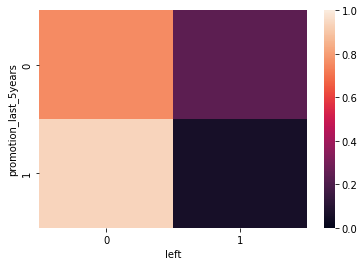

In [ ]:
_ = xtab(dataset.promotion_last_5years, dataset.left, normalize_rows=True)

3

In [ ]:
dataset.satisfaction_level.describe()

count    14999.000000
mean         0.612834
std          0.248631
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

In [ ]:
# I dipendenti risultano abbastanza soddisfatti: sia media che mediana sono
# superiori a 0.6

4

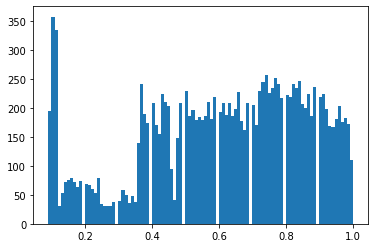

In [ ]:
_, bins_bounds, _ = plt.hist(dataset.satisfaction_level, bins=100)

In [ ]:
first_bin = dataset[(dataset.satisfaction_level >= bins_bounds[0]) &
        (dataset.satisfaction_level < bins_bounds[1])]

In [ ]:
first_bin.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,1.950000e+02,195.000000,195.000000,195.000000,195.000000,195.000000,195.0,195.0
mean,9.000000e-02,0.871538,6.179487,275.692308,4.107692,0.020513,1.0,0.0
std,9.739457e-17,0.070789,0.595161,20.310672,0.398052,0.142111,0.0,0.0
min,9.000000e-02,0.620000,3.000000,214.000000,2.000000,0.000000,1.0,0.0
25%,9.000000e-02,0.820000,6.000000,257.500000,4.000000,0.000000,1.0,0.0
50%,9.000000e-02,0.870000,6.000000,275.000000,4.000000,0.000000,1.0,0.0
75%,9.000000e-02,0.935000,6.500000,294.000000,4.000000,0.000000,1.0,0.0
max,9.000000e-02,0.980000,7.000000,310.000000,5.000000,1.000000,1.0,0.0


In [ ]:
for c in first_bin.columns:
  vc = first_bin[c].value_counts()
  if vc.size == 1:
    print(vc)

0.09    195
Name: satisfaction_level, dtype: int64
1    195
Name: left, dtype: int64
0    195
Name: promotion_last_5years, dtype: int64


In [ ]:
# Dei 195 dipendenti con il livello di soddisfazione più basso, nessuno ha avuto
# una promozione nei 5 anni passati e tutti hanno lasciato l'attività

4

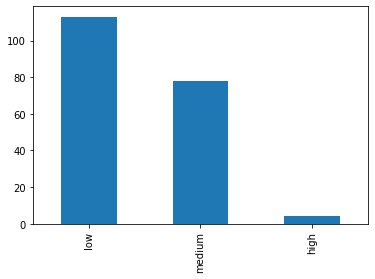

In [ ]:
_ = first_bin.salary.value_counts().plot(kind='bar')

5

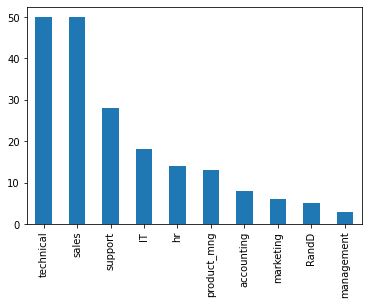

In [ ]:
_ = first_bin.sales.value_counts().plot(kind='bar')

In [ ]:
first_bin.sales.value_counts()

technical      50
sales          50
support        28
IT             18
hr             14
product_mng    13
accounting      8
marketing       6
RandD           5
management      3
Name: sales, dtype: int64

In [ ]:
# Nei settori technical e sales si verifica il maggior numero di abbandoni

# Parte 2: Trasformazione e Predizione

1

In [ ]:
dataset.info()
# salary e sales sono colonne categoriche

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [ ]:
reduced = dataset.drop(columns=['salary', 'sales'])

2

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
salary = ['low', 'medium', 'high'] # forzo ordinamento crescente
sales = dataset.sales.unique() # non importa l'ordinamento

columns = ['salary', 'sales']

enc = OrdinalEncoder(categories=[salary, sales]).fit(dataset[columns])
ds_enc = pd.DataFrame(enc.transform(dataset[columns]), columns=columns)

dataset1 = pd.concat([dataset.drop(columns=columns), ds_enc], axis=1)
dataset1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0
1,0.80,0.86,5,262,6,0,1,0,1.0,0.0
2,0.11,0.88,7,272,4,0,1,0,1.0,0.0
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0


3

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
train, test = train_test_split(dataset1, train_size=.75, random_state=1)

Accuracy: 0.7674666666666666
Confusion matrix:
 [[2839   14]
 [ 858   39]]


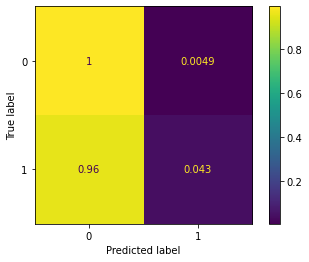

In [ ]:
_ = fit_predict_print(train, test, 'left', MultinomialNB())

In [ ]:
train, test = train_test_split(reduced, train_size=.75, random_state=1)

Accuracy: 0.7608
Confusion matrix:
 [[2853    0]
 [ 897    0]]


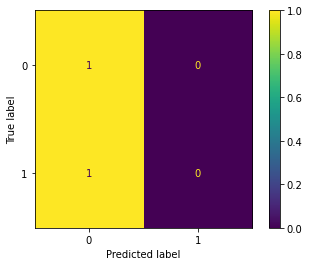

In [ ]:
_ = fit_predict_print(train, test, 'left', MultinomialNB())

4

In [ ]:
# L'accuratezza elevata è dovuta alla netta prevalenza della classe '0', che
# viene predetta correttamente, mentre le predizioni per la classe '1' sono
# quasi interamente sbagliate.

5

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
train, test = train_test_split(dataset1, train_size=.75, random_state=1)

Accuracy: 0.9752
Confusion matrix:
 [[2787   66]
 [  27  870]]


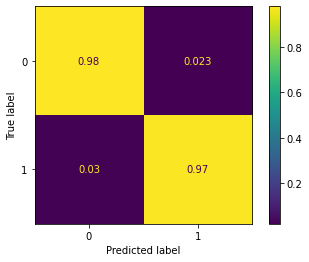

In [ ]:
_ = fit_predict_print(train, test, 'left', DecisionTreeClassifier())

In [ ]:
train, test = train_test_split(reduced, train_size=.75, random_state=1)

Accuracy: 0.9770666666666666
Confusion matrix:
 [[2792   61]
 [  25  872]]


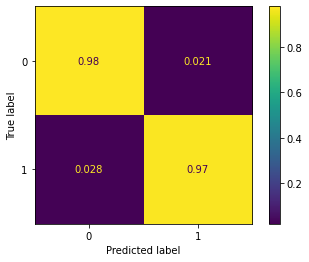

In [ ]:
_ = fit_predict_print(train, test, 'left', DecisionTreeClassifier())

In [ ]:
# L'accuratezza risulta elevatissima per entrambe le classi

6

In [ ]:
X = dataset1.drop(columns='left')
y = dataset1.left

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y, cv=5, scoring='accuracy',
                n_jobs=-1).mean()

0.975931688340558

In [ ]:
cross_val_score(MultinomialNB(), X, y, cv=5, scoring='accuracy',
                n_jobs=-1).mean()
# Sospetto che rimanga il problema visto in precedenza con il MultinomialNB

0.7624486606646661

7

In [ ]:
Xb, yb = balanced_subsample(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
yb.value_counts()

0.0    3571
1.0    3571
dtype: int64

In [ ]:
cross_val_score(DecisionTreeClassifier(), Xb, yb, cv=5, scoring='accuracy',
                n_jobs=-1).mean()

0.9617757809911929

In [ ]:
cross_val_score(MultinomialNB(), Xb, yb, cv=5, scoring='accuracy',
                n_jobs=-1).mean()

0.6521965959231838

In [ ]:
# L'accuratezza (elevatissima) non varia significativamente con il DecisionTree,
# ma cala con il MultinomialNB. Non è possibile valutare se lo scostamento dei
# valori di accuratezza per ogni classe sono cambiati

8

In [ ]:
columns

['salary', 'sales']

In [ ]:
dataset2 = add_dummies(dataset, columns)

In [ ]:
dataset2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,low,medium,high,sales,accounting,hr,technical,support,management,IT,product_mng,marketing,RandD
0,0.38,0.53,2,157,3,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.80,0.86,5,262,6,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.11,0.88,7,272,4,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.72,0.87,5,223,5,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.37,0.52,2,159,3,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train, test = train_test_split(dataset2, train_size=.75, random_state=1)

Accuracy: 0.7602666666666666
Confusion matrix:
 [[2851    2]
 [ 897    0]]


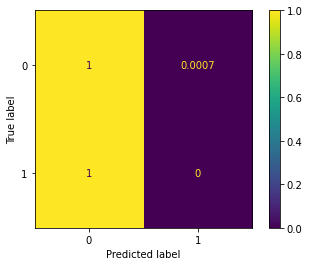

In [ ]:
_ = fit_predict_print(train, test, 'left', MultinomialNB())

Accuracy: 0.9792
Confusion matrix:
 [[2801   52]
 [  26  871]]


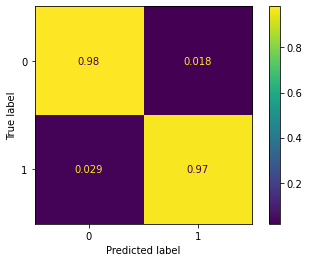

In [ ]:
_ = fit_predict_print(train, test, 'left', DecisionTreeClassifier())

In [ ]:
# L'accuratezza non cambia significativamente.
# La trasformazione di attributi categorici in one-hot-encode è preferibile
# a una conversione in numeri perchè non stabilisce alcun tipo di relazione
# numerica tra le classi.
# In particolare per l'attributo 'sales', la conversione in numeri implica un
# ordinamento che nella realtà non ha alcun senso.

9

In [ ]:
dataset3 = dataset1.copy()

In [ ]:
dataset3.average_montly_hours = pd.cut(dataset3.average_montly_hours, bins=6,
                                       labels=range(1, 7))

In [ ]:
dataset3.average_montly_hours

0        2
1        5
2        5
3        4
4        2
        ..
14994    2
14995    2
14996    2
14997    6
14998    2
Name: average_montly_hours, Length: 14999, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [ ]:
train, test = train_test_split(dataset3, train_size=.75, random_state=1)

Accuracy: 0.7576
Confusion matrix:
 [[2839   14]
 [ 895    2]]


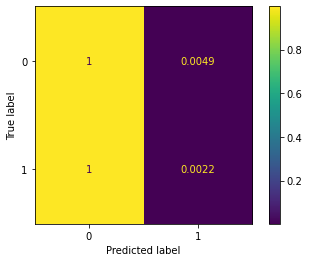

In [ ]:
_ = fit_predict_print(train, test, 'left', MultinomialNB())

Accuracy: 0.9749333333333333
Confusion matrix:
 [[2785   68]
 [  26  871]]


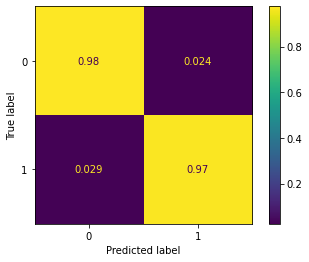

In [ ]:
_ = fit_predict_print(train, test, 'left', DecisionTreeClassifier())

10

left                       0         1
satisfaction_level                    
0.09                0.000000  1.000000
0.10                0.000000  1.000000
0.11                0.000000  1.000000
0.12                0.866667  0.133333
0.13                0.944444  0.055556
...                      ...       ...
0.96                1.000000  0.000000
0.97                1.000000  0.000000
0.98                1.000000  0.000000
0.99                1.000000  0.000000
1.00                1.000000  0.000000

[92 rows x 2 columns]
left                    0         1
last_evaluation                    
0.36             1.000000  0.000000
0.37             1.000000  0.000000
0.38             1.000000  0.000000
0.39             1.000000  0.000000
0.40             1.000000  0.000000
...                   ...       ...
0.96             0.730924  0.269076
0.97             0.695652  0.304348
0.98             0.756654  0.243346
0.99             0.744186  0.255814
1.00             0.409894  0.590106

[

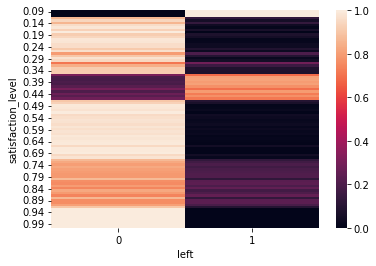

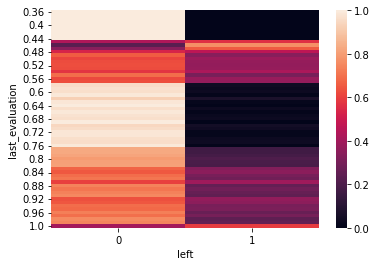

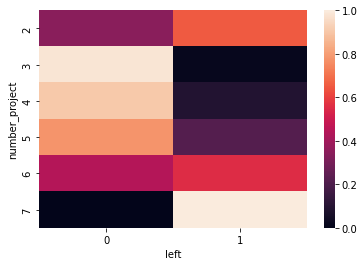

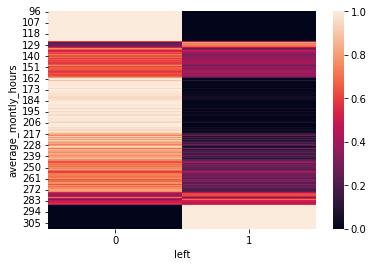

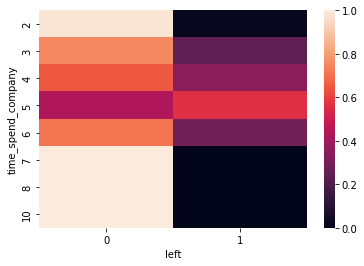

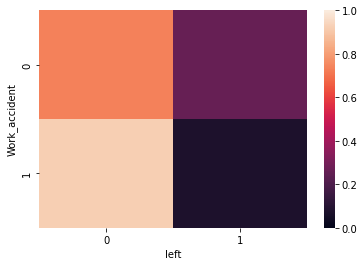

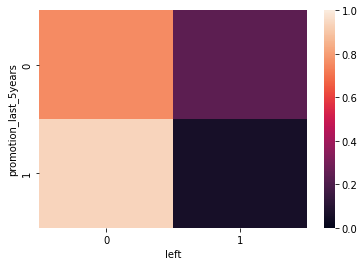

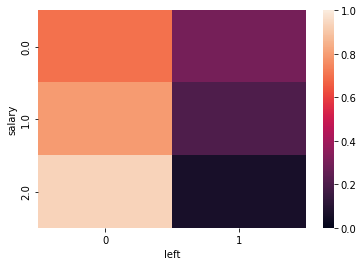

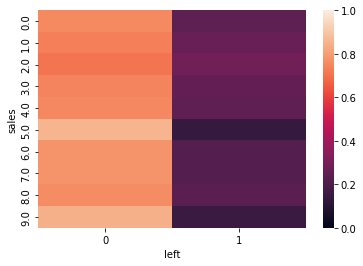

In [ ]:
features = dataset1.columns.drop('left')
for f in features:
  plt.figure()
  _ = xtab(dataset1[f], dataset1.left, normalize_rows=True)

In [ ]:
dataset3.last_evaluation = pd.cut(dataset3.last_evaluation, bins=6,
                                  labels=range(1, 7))
dataset3.satisfaction_level = pd.cut(dataset3.satisfaction_level, bins=6,
                                  labels=range(1, 7))

In [ ]:
train, test = train_test_split(dataset3, train_size=.75, random_state=1)

Accuracy: 0.7914666666666667
Confusion matrix:
 [[2737  116]
 [ 666  231]]


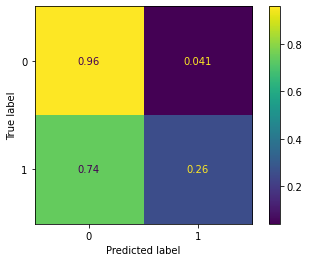

In [ ]:
_ = fit_predict_print(train, test, 'left', MultinomialNB())

Accuracy: 0.9661333333333333
Confusion matrix:
 [[2769   84]
 [  43  854]]


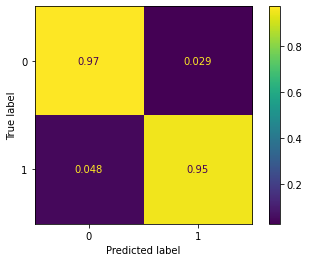

In [ ]:
_ = fit_predict_print(train, test, 'left', DecisionTreeClassifier())